## Load modules

In [18]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
sys.path.insert(1, '../../../') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
u.check_virtual_memory()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
3.7.6 (default, Jan  8 2020, 19:59:22) 
[GCC 7.3.0]
Virtual memory usage - total: 126 GB / available: 110 GB / percent used: 12.6 %


## Load model data

In [19]:
# Define period
period = slice('1981','2014')

In [20]:
institute = 'IPSL'
model = 'IPSL-CM6A-LR'
realization = 'r1i1p1f1'
var = 'tas'
if var in ['tas', 'pr']:
    table = 'Amon'

In [21]:
# Load historical
da_historical = xr.open_mfdataset(
    '/bdd/CMIP6/CMIP/'+institute+'/'+model+'/historical/'+realization+'/'+table+'/'+var+'/gr/latest/*.nc', combine='by_coords'
).sel(time=period)[var]

# Load amip
da_amip = xr.open_mfdataset(
    '/bdd/CMIP6/CMIP/'+institute+'/'+model+'/amip/'+realization+'/'+table+'/'+var+'/gr/latest/*.nc', combine='by_coords'
).sel(time=period)[var]

# Load land-hist
da_land_hist = xr.open_mfdataset(
    '/bdd/CMIP6/LS3MIP/'+institute+'/'+model+'/land-hist/'+realization+'/'+table+'/'+var+'/gr/latest/*.nc', combine='by_coords'
).sel(time=period)[var]

# Load HighResMIP
da_HR = xr.open_mfdataset(
    '/bdd/CMIP6/HighResMIP/'+institute+'/IPSL-CM6A-ATM-HR/highresSST-present/'+realization+'/'+table+'/'+var+'/gr/latest/*.nc', combine='by_coords'
).sel(time=period)[var]

In [22]:
da_HR

<xarray.DataArray 'tas' (time: 408, lat: 361, lon: 512)>
dask.array<getitem, shape=(408, 361, 512), dtype=float32, chunksize=(408, 361, 512), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float32 0.0 0.703125 1.40625 ... 358.59375 359.29688
    height   float64 ...
  * time     (time) datetime64[ns] 1981-01-16T12:00:00 ... 2014-12-16T12:00:00
Attributes:
    online_operation:    average
    cell_methods:        area: time: mean
    interval_operation:  900 s
    interval_write:      1 month
    standard_name:       air_temperature
    description:         Near-Surface Air Temperature
    long_name:           Near-Surface Air Temperature
    history:             none
    units:               K
    cell_measures:       area: areacella

## Load obs 
Attention en °C

In [23]:
obs = xr.open_mfdataset(
    '/bdd/cru/cru_ts_4.00/data/tmp/cru_ts4.00.*.tmp.dat.nc', combine='nested', concat_dim='time'
).isel(
    time=slice(1080,1488)
).tmp
obs

<xarray.DataArray 'tmp' (time: 408, lat: 360, lon: 720)>
dask.array<getitem, shape=(408, 360, 720), dtype=float32, chunksize=(408, 360, 720), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float32 -179.75 -179.25 -178.75 ... 178.75 179.25 179.75
  * lat      (lat) float32 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * time     (time) datetime64[ns] 1981-01-16 1981-02-15 ... 2014-12-16
Attributes:
    long_name:                   near-surface temperature
    units:                       degrees Celsius
    correlation_decay_distance:  1200.0

### Regrid using xESMF (https://xesmf.readthedocs.io/en/latest/) 
obs + HR

In [24]:
# Make the regrider
regridder_obs = xe.Regridder(obs, da_historical, 'bilinear', periodic=True)
regridder_obs

Overwrite existing file: bilinear_360x720_143x144_peri.nc 
 You can set reuse_weights=True to save computing time.


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_360x720_143x144_peri.nc 
Reuse pre-computed weights? False 
Input grid shape:           (360, 720) 
Output grid shape:          (143, 144) 
Output grid dimension name: ('lat', 'lon') 
Periodic in longitude?      True

In [25]:
# Regrid the data
obs_regrid = regridder_obs(obs)

/home/mlalande/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/home/mlalande/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


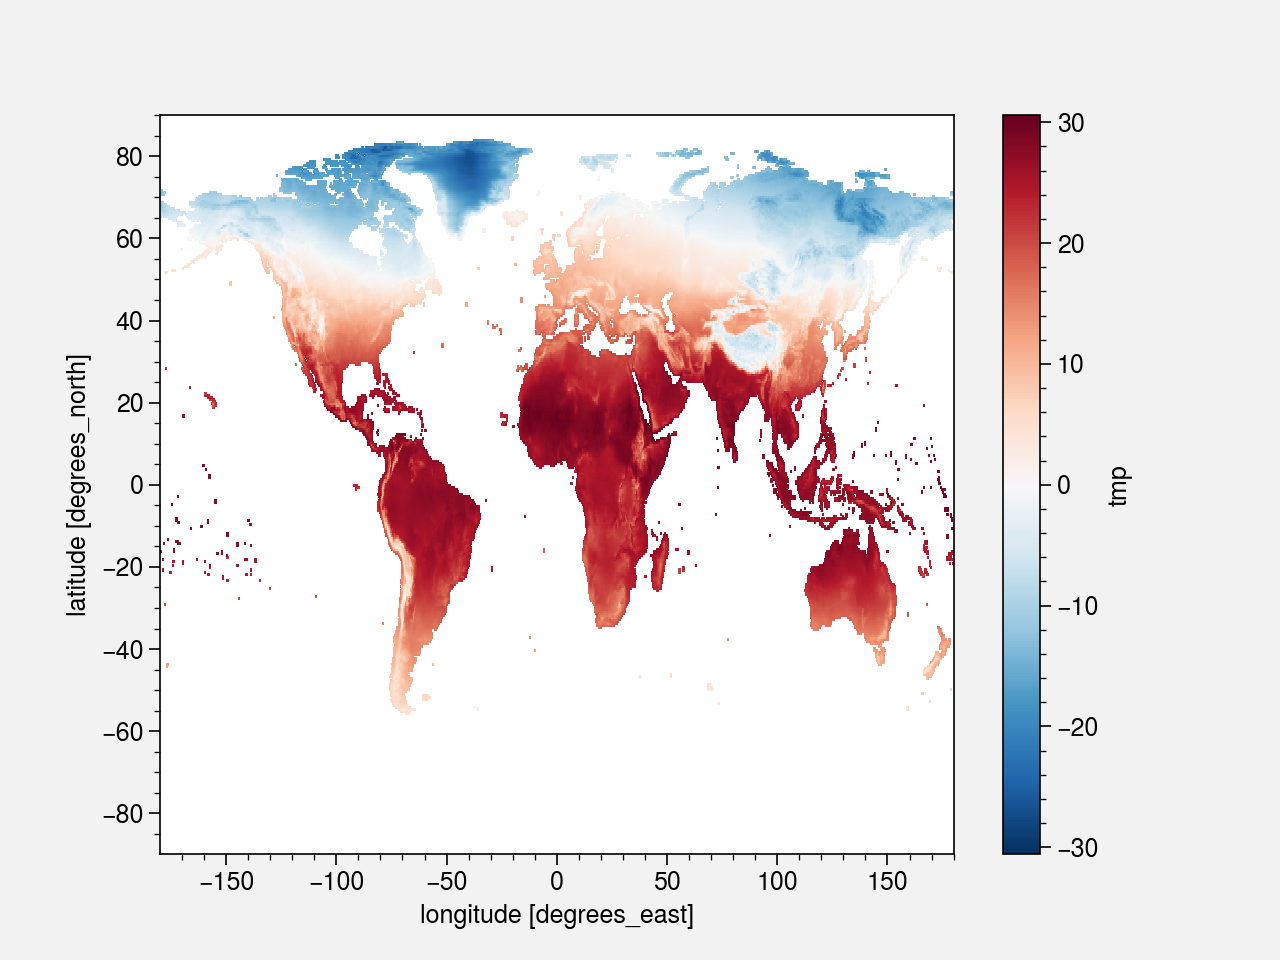

In [26]:
obs.mean('time').plot()

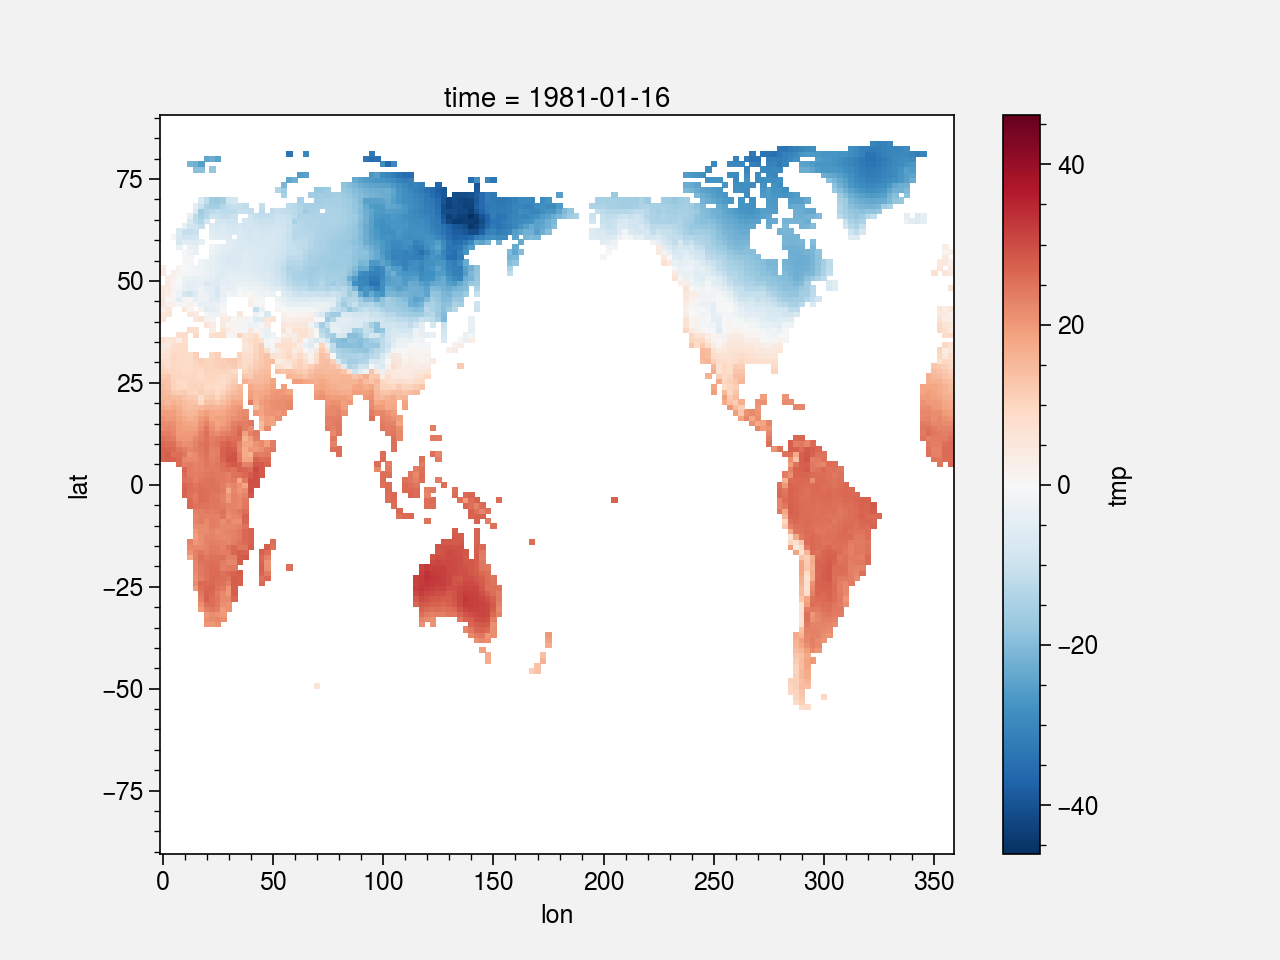

In [27]:
obs_regrid[0].plot()

In [28]:
# Regrid HighResMIP
regridder_HR = xe.Regridder(da_HR, da_historical, 'bilinear', periodic=True)
regridder_HR

Overwrite existing file: bilinear_361x512_143x144_peri.nc 
 You can set reuse_weights=True to save computing time.


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_361x512_143x144_peri.nc 
Reuse pre-computed weights? False 
Input grid shape:           (361, 512) 
Output grid shape:          (143, 144) 
Output grid dimension name: ('lat', 'lon') 
Periodic in longitude?      True

In [29]:
# Regrid the data
da_HR_regrid = regridder_HR(da_HR)

## Annual Climatology

In [30]:
da_historical_clim = u.clim(da_historical)
da_historical_clim.load()

da_amip_clim = u.clim(da_amip)
da_amip_clim.load()

da_land_hist_clim = u.clim(da_land_hist)
da_land_hist_clim.load()

obs_regrid_clim = u.clim(obs_regrid)
obs_regrid_clim.load()

da_HR_regrid_clim = u.clim(da_HR_regrid)
da_HR_regrid_clim.load()

<xarray.DataArray (lat: 143, lon: 144)>
array([[222.60601027, 222.60601027, 222.60601027, ..., 222.60601027,
        222.60601027, 222.60601027],
       [223.83710769, 223.75769107, 223.67610714, ..., 224.00801178,
        223.95048942, 223.89538481],
       [224.71583691, 224.52909939, 224.34831869, ..., 225.27368456,
        225.08876336, 224.90382298],
       ...,
       [257.69657042, 257.71809574, 257.73945296, ..., 257.62329174,
        257.6511605 , 257.67557259],
       [257.43398159, 257.44407328, 257.45365872, ..., 257.40299762,
        257.41481156, 257.42652087],
       [256.77828045, 256.77828045, 256.77828045, ..., 256.77828045,
        256.77828045, 256.77828045]])
Coordinates:
    height   float64 2.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat      (lat) float32 -90.0 -88.73239 -87.46479 ... 87.46479 88.73239 90.0
Attributes:
    regrid_method:  bilinear

In [34]:
latlim=(10,50)
lonlim=(60,110)

bias = xr.concat(
    [
        ((da_historical_clim-273.15)-obs_regrid_clim),
        ((da_amip_clim-273.15)-obs_regrid_clim),
        ((da_land_hist_clim-273.15)-obs_regrid_clim),
        ((da_HR_regrid_clim-273.15)-obs_regrid_clim)
    ],
    pd.Index(
        [
            'Historical (143x144) - CRU (0.5°)',
            'AMIP (143x144) - CRU (0.5°)',
            'land-hist (143x144) - CRU (0.5°)',
            'HighResMIP (361x512) - CRU (0.5°)'
        ], 
        name='bias'
    )
).sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1]))

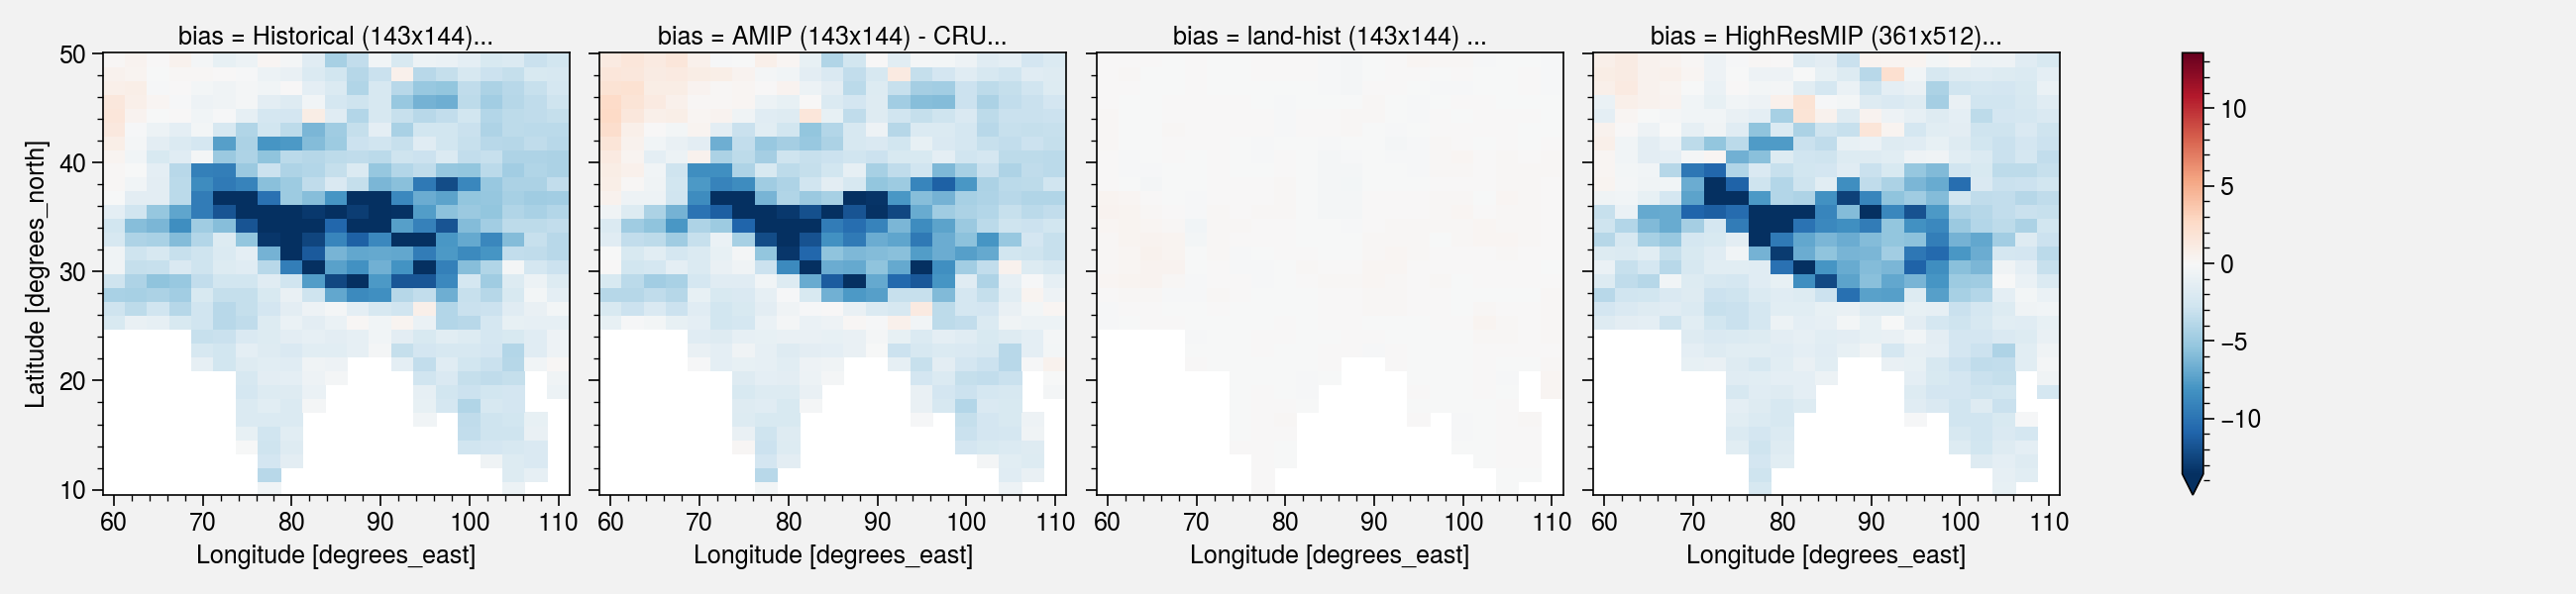

In [35]:
bias.plot(col='bias', robust=True)

In [36]:
bias.min()

<xarray.DataArray ()>
array(-18.30030714)
Coordinates:
    height   float64 2.0

In [37]:
bias.max()

<xarray.DataArray ()>
array(2.66386412)
Coordinates:
    height   float64 2.0

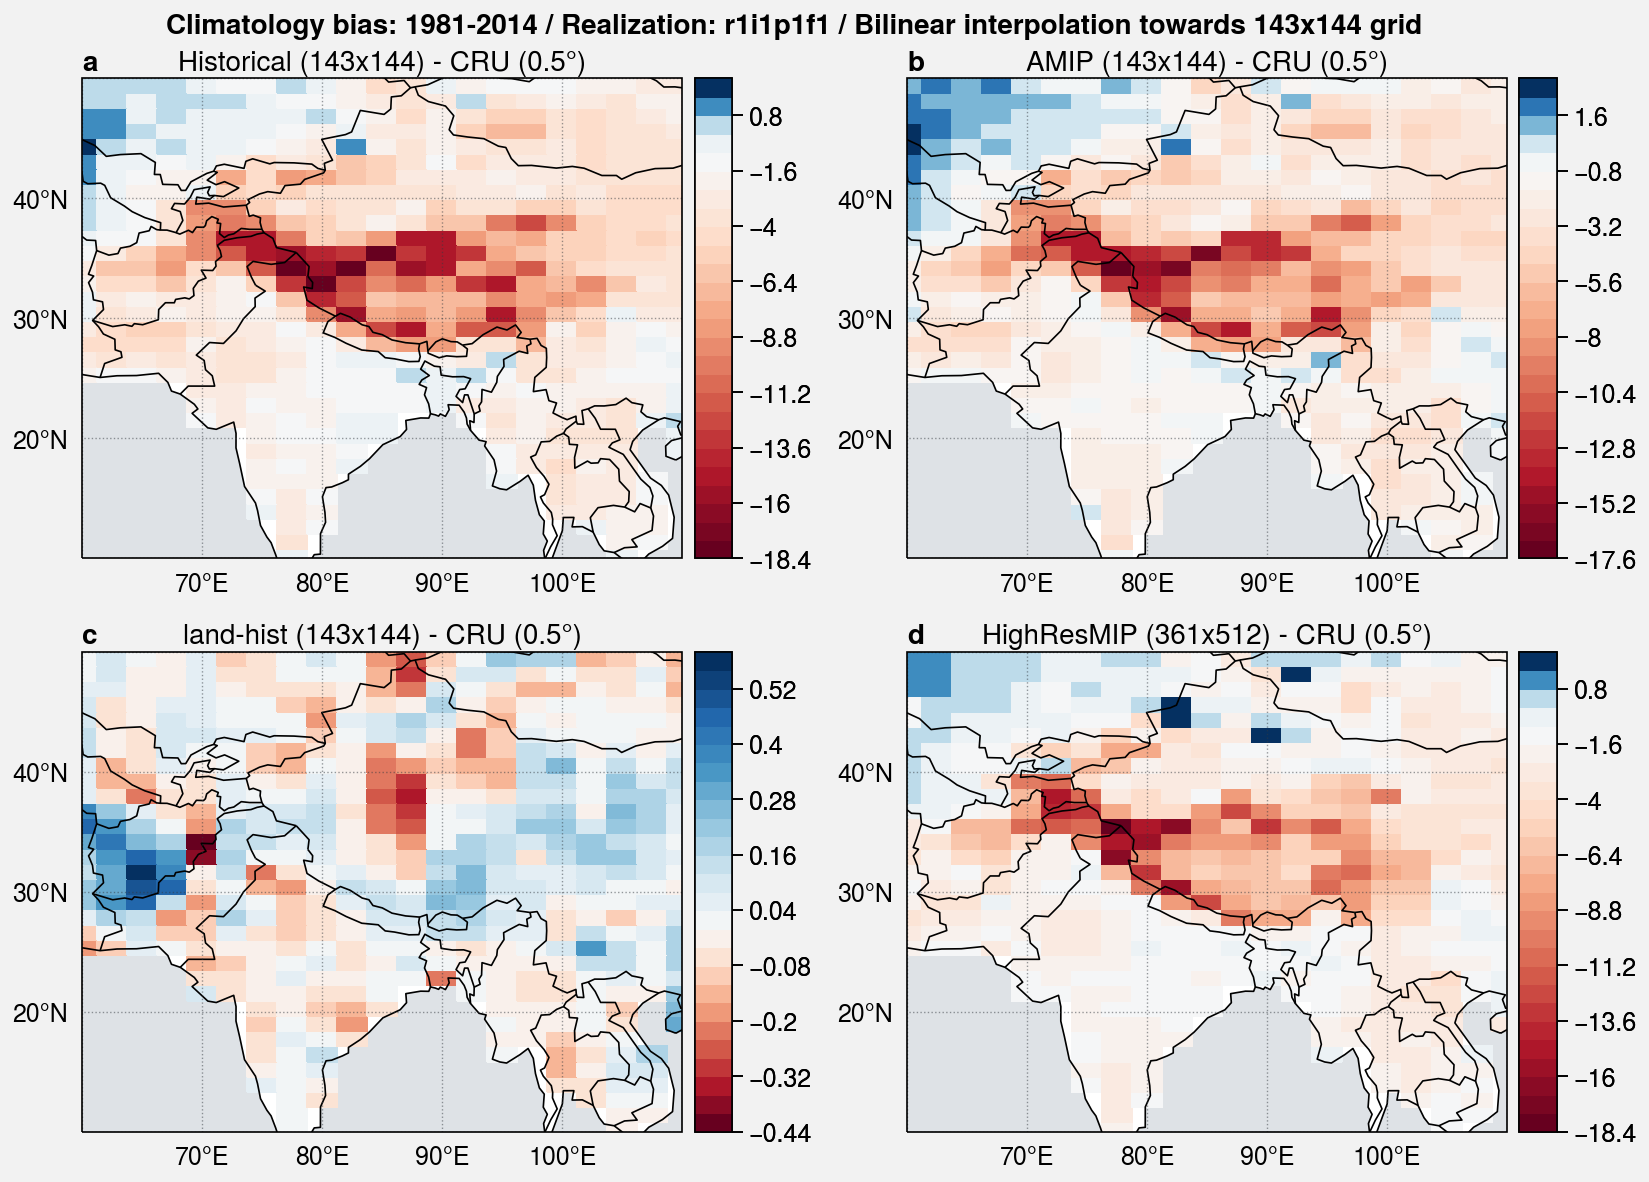

In [38]:
# Check colorbars extent

f, axs = plot.subplots(proj='cyl', ncols=2, nrows=2, share=3, axwidth=3)

for i, ax in enumerate(axs):
    m = ax.pcolormesh(
        bias.isel(bias=i), 
        cmap='RdBu',  
        colorbar='r',
        norm='midpoint',
        levels=30
    )
    ax.format(title=str(bias.isel(bias=i).bias.values))

axs.format(
    geogridlinewidth=0.5, geogridcolor='gray8', geogridalpha=0.5, labels=True, 
    coast=True, ocean=True, oceancolor='gray3', borders=True,
    suptitle="Climatology bias: 1981-2014 / Realization: r1i1p1f1 / Bilinear interpolation towards 143x144 grid",
    lonlines=10, latlines=10, abc=True, latlim=latlim, lonlim=lonlim
)

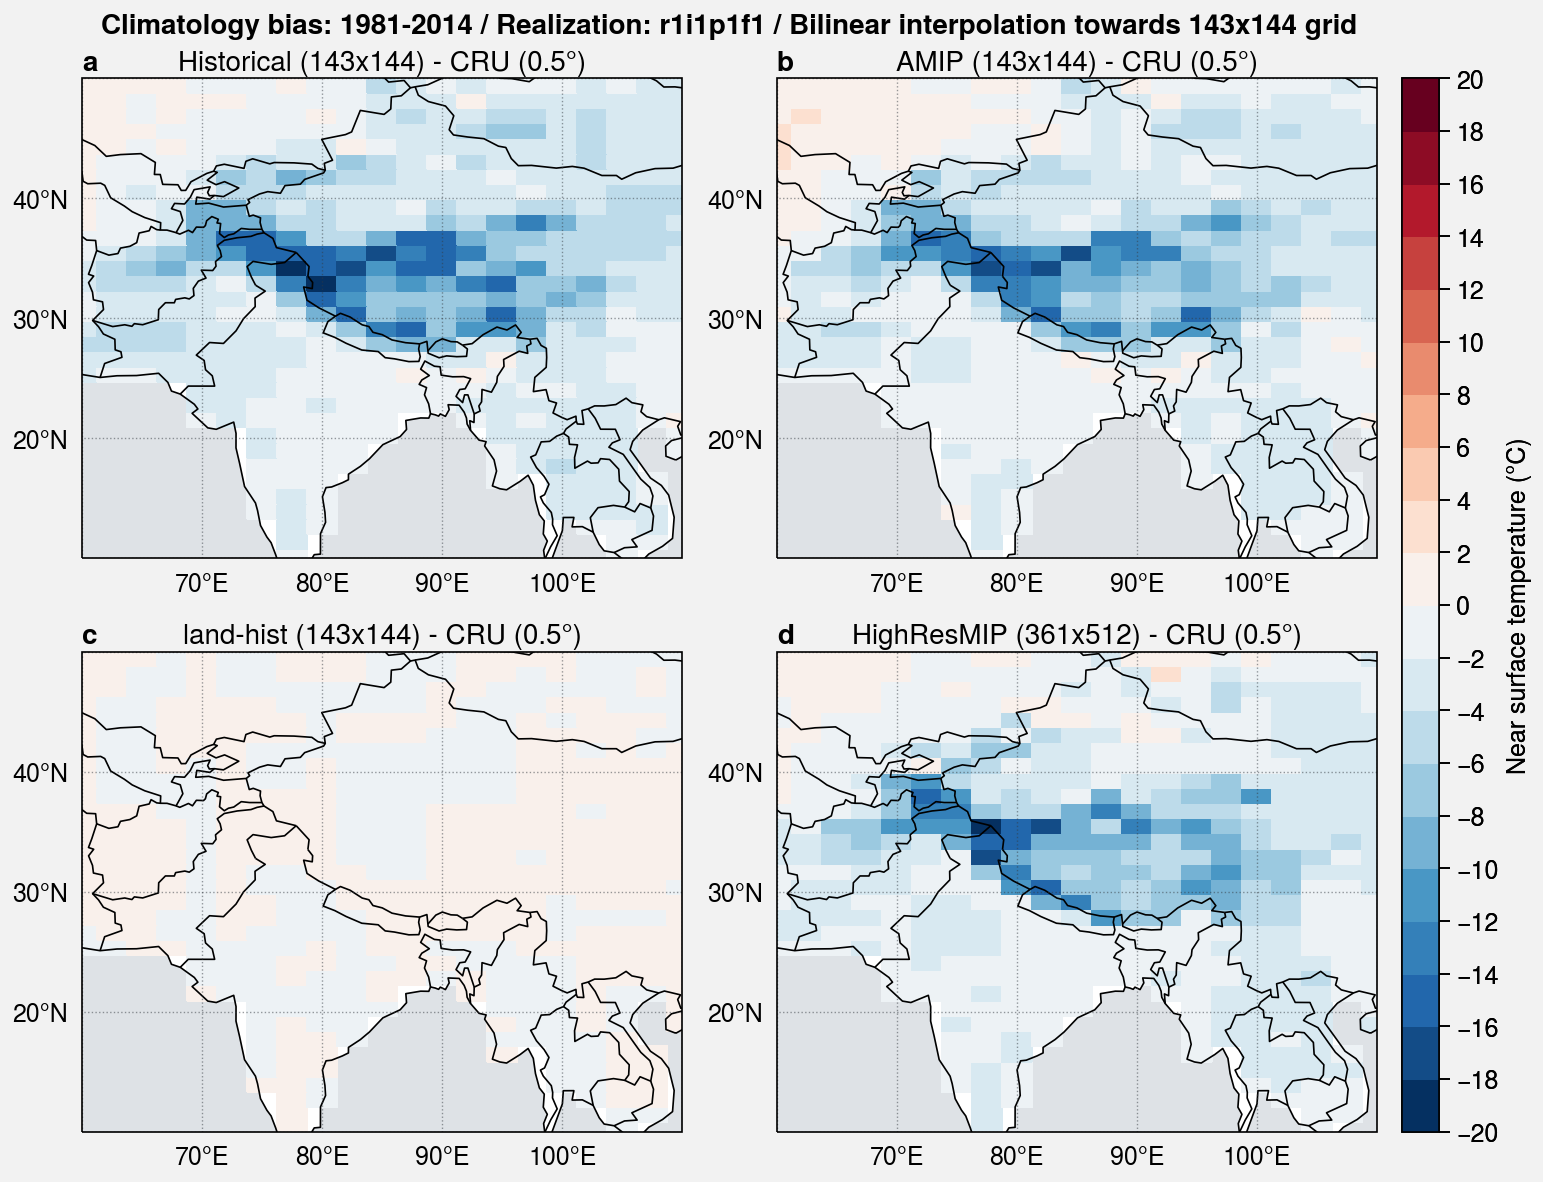

In [43]:
# Final plot

f, axs = plot.subplots(proj='cyl', ncols=2, nrows=2, share=3, axwidth=3)

for i, ax in enumerate(axs):
    m = ax.pcolormesh(
        bias.isel(bias=i), 
        cmap='RdBu_r', 
        levels=plot.arange(-20,20,2), 
#         extend='both',
#         norm='midpoint'
    )
    ax.format(title=str(bias.isel(bias=i).bias.values))

f.colorbar(m, label='Near surface temperature (°C)')

axs.format(
    geogridlinewidth=0.5, geogridcolor='gray8', geogridalpha=0.5, labels=True, 
    coast=True, ocean=True, oceancolor='gray3', borders=True,
    suptitle="Climatology bias: 1981-2014 / Realization: r1i1p1f1 / Bilinear interpolation towards 143x144 grid",
    lonlines=10, latlines=10, abc=True, latlim=latlim, lonlim=lonlim
)

f.save('img/tas_IPSL_CMIP6_bias.pdf')

# Annual cycle on the bias zone

In [45]:
lonlim_zone=(78,78+20)
latlim_zone=(27,27+11)

# Compute annual cycles on the zone
ac_historical = u.annual_cycle(u.spatial_average(
    da_historical.sel(lon=slice(lonlim_zone[0],lonlim_zone[1]), lat=slice(latlim_zone[0],latlim_zone[1]))-273.15
)).load()
ac_amip = u.annual_cycle(u.spatial_average(
    da_amip.sel(lon=slice(lonlim_zone[0],lonlim_zone[1]), lat=slice(latlim_zone[0],latlim_zone[1]))-273.15
)).load()
ac_land_hist = u.annual_cycle(u.spatial_average(
    da_land_hist.sel(lon=slice(lonlim_zone[0],lonlim_zone[1]), lat=slice(latlim_zone[0],latlim_zone[1]))-273.15
)).load()
ac_obs_regrid = u.annual_cycle(u.spatial_average(
    obs_regrid.sel(lon=slice(lonlim_zone[0],lonlim_zone[1]), lat=slice(latlim_zone[0],latlim_zone[1]))
)).load()
ac_HR_regrid = u.annual_cycle(u.spatial_average(
    da_HR_regrid.sel(lon=slice(lonlim_zone[0],lonlim_zone[1]), lat=slice(latlim_zone[0],latlim_zone[1]))-273.15
)).load()

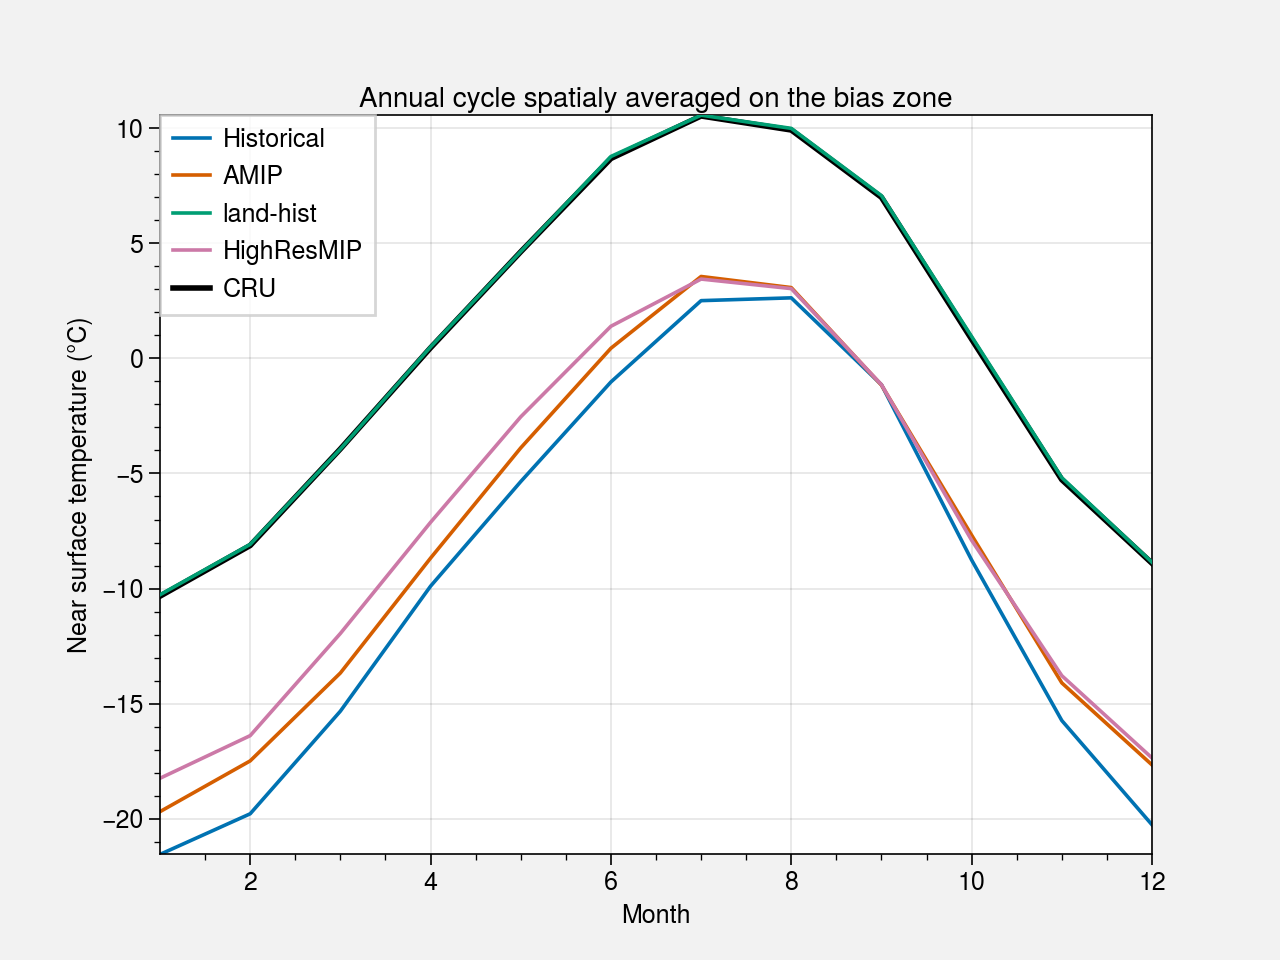

In [52]:
plt.figure()

ac_historical.plot(label='Historical')
ac_amip.plot(label='AMIP')
ac_land_hist.plot(label='land-hist', zorder=10)
ac_HR_regrid.plot(label='HighResMIP')

ac_obs_regrid.plot(label='CRU', color='black', linewidth=2)

plt.title('Annual cycle spatialy averaged on the bias zone')
# plt.ylim(0,100)
plt.ylabel('Near surface temperature (°C)')
plt.xlabel('Month')
plt.legend()

plt.savefig('img/ac_tas_IPSL_CMIP6.pdf')

# Check ensemble dispersion for historical

In [48]:
da_historical_ens = xr.open_mfdataset(
    '/bdd/CMIP6/CMIP/'+institute+'/'+model+'/historical/*/'+table+'/'+var+'/gr/latest/*.nc', combine='nested', concat_dim='realization', parallel=True
).sel(time=period, lon=slice(lonlim_zone[0],lonlim_zone[1]), lat=slice(latlim_zone[0],latlim_zone[1]))[var]
da_historical_ens

<xarray.DataArray 'tas' (realization: 32, time: 408, lat: 8, lon: 8)>
dask.array<getitem, shape=(32, 408, 8, 8), dtype=float32, chunksize=(1, 408, 8, 8), chunktype=numpy.ndarray>
Coordinates:
    height   float64 2.0
  * lon      (lon) float32 80.0 82.5 85.0 87.5 90.0 92.5 95.0 97.5
  * lat      (lat) float32 27.887323 29.15493 30.422535 ... 35.492958 36.760563
  * time     (time) datetime64[ns] 1981-01-16T12:00:00 ... 2014-12-16T12:00:00
Dimensions without coordinates: realization
Attributes:
    online_operation:    average
    cell_methods:        area: time: mean
    interval_operation:  900 s
    interval_write:      1 month
    standard_name:       air_temperature
    long_name:           Near-Surface Air Temperature
    history:             none
    units:               K
    cell_measures:       area: areacella

In [49]:
ac_historical_ens = u.annual_cycle(u.spatial_average(da_historical_ens)).load()

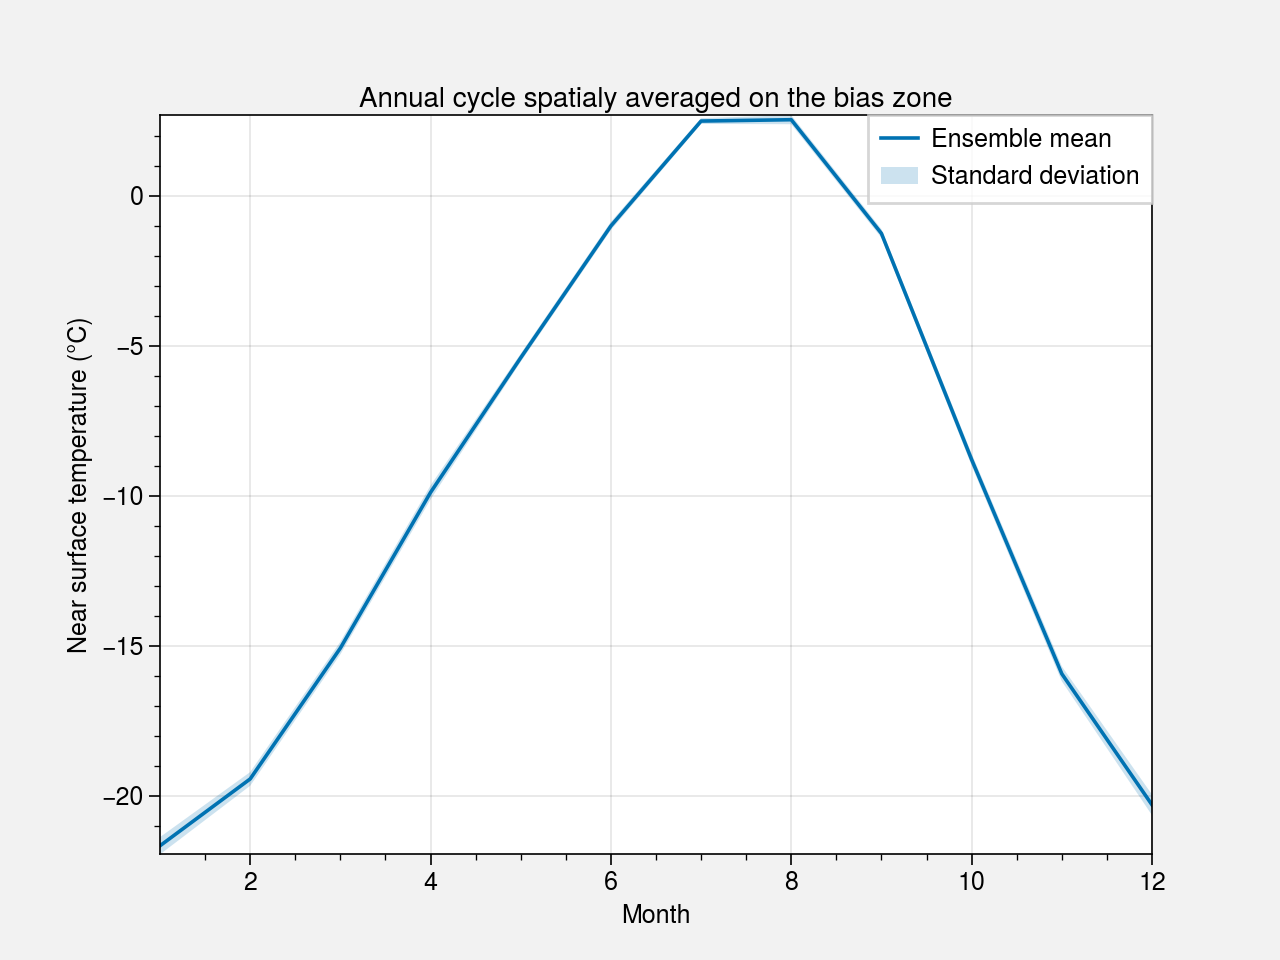

In [50]:
x = ac_historical_ens.month
y = (ac_historical_ens-273.15).mean('realization')
std = (ac_historical_ens-273.15).std('realization')

fig, ax = plt.subplots()

y.plot(ax=ax, label='Ensemble mean')
ax.fill_between(x, y-std, y+std, alpha=0.2, label='Standard deviation')

plt.title('Annual cycle spatialy averaged on the bias zone')
# plt.ylim(0,100)
plt.ylabel('Near surface temperature (°C)')
plt.xlabel('Month')
plt.legend()

Text(0.5, 0, 'Month')

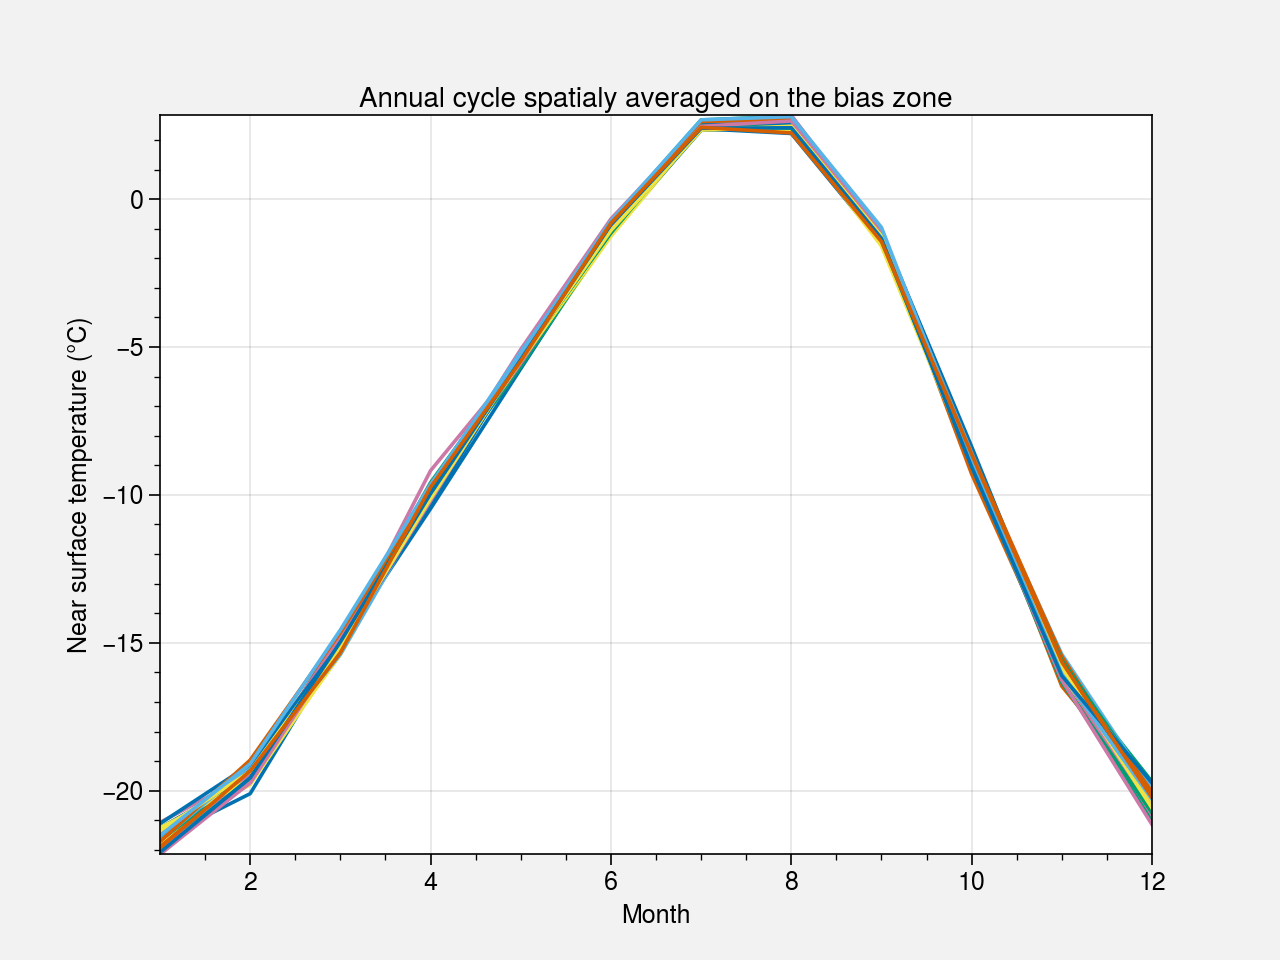

In [51]:
fig, ax = plt.subplots()

for i in ac_historical_ens.realization.values:
    (ac_historical_ens[i]-273.15).plot(ax=ax)

plt.title('Annual cycle spatialy averaged on the bias zone')
# plt.ylim(0,100)
plt.ylabel('Near surface temperature (°C)')
plt.xlabel('Month')
# plt.legend()